## Goal
Practice on data processing and know how-to use fastai's data block API

### About Dataset
German Traffic Sign Recognition Benchmark dataset is probably the most popular image classification related to self-driving cars. Autonomous vehicles need to detect and classify traffic signs to understand traffic rules applied to a segment of the road. Perhaps, this dataset is too small and incomplete to use it for real applications. Nevertheless, it is a good benchmark of computer vision algorithms.

#### From Kaggle
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

Single-image, multi-class classification problem
More than 40 classes
More than 50,000 images in total
Large, lifelike database

In [67]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [68]:
from fastai.vision import *

In [104]:
import csv
from collections import defaultdict, namedtuple

import os
import shutil

import numpy as np

### Getting the data

In [70]:
# create data folder
path = Config.data_path()/'gtsrb'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/Tim/.fastai/data/gtsrb')

In [71]:
# Download and unpack the training set and the test set
# The dataset has been moved here, https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html 

# ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P {path}
# ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P {path}
# ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P {path}
    
# ! unzip path/GTSRB_Final_Training_Images.zip -d {path}
# ! unzip path/GTSRB_Final_Test_Images.zip -d {path}
# ! unzip path/GTSRB_Final_Test_GT.zip -d {path}

In [72]:
# Download class names
# ! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P {path}

In [73]:
Annotation = namedtuple('Annotation', ['filename', 'label'])
def read_annotations(filename):
    annotations = []
    
    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
            
    return annotations

In [74]:
def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

def copy_files(label, filenames, source, destination, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    for filename in filenames:
        destination_path = os.path.join(label_path, filename)
        if not os.path.exists(destination_path):
            func(os.path.join(source, format(label, '05d'), filename), destination_path)

def split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    """
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
        
    if not os.path.exists(all_path):
        os.makedirs(all_path)
    
    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        validation_size = int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        copy_files(label, filenames, source_path, all_path, move=False)
        copy_files(label, train_filenames, source_path, train_path, move=True)
        copy_files(label, validation_filenames, source_path, validation_path, move=True)

In [75]:
source_path = path/'GTSRB/Final_Training/Images'
train_path = path/'train'
validation_path = path/'valid'
all_path = path/'all'
validation_fraction = 0.2
# split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction)

path.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/all'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/export.pkl'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/from_kaggle'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/ftest'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/ftest1'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GT-final_test.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GT-final_testdev.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Final_Test_GT.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Final_Test_Images.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Final_Training_Images.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/models'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/signnames.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/test'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/test1'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/train'),
 WindowsP

In [76]:
test_path = path/'GT-final_test.csv'
test_annotations = read_annotations(test_path)

In [77]:
classes = pd.read_csv(path/'signnames.csv')

class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

class_names

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '2': 'Speed limit (50km/h)',
 '3': 'Speed limit (60km/h)',
 '4': 'Speed limit (70km/h)',
 '5': 'Speed limit (80km/h)',
 '6': 'End of speed limit (80km/h)',
 '7': 'Speed limit (100km/h)',
 '8': 'Speed limit (120km/h)',
 '9': 'No passing',
 '10': 'No passing for vechiles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vechiles',
 '16': 'Vechiles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn 

### build data bunch

In [78]:
bs = 160

# don't flip, flip won't help, sometimes flip a traffic sign changes the whole meaning. can allow some rotate, some warp(形变)

tfms = get_transforms(do_flip=False, max_lighting=0.2, max_zoom=1.2, max_rotate=20, max_warp=0.1)

In [79]:
src = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder())              #Optionally add a test set (here default name is test)


In [80]:
data = (src.transform(tfms, size=96)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs))                   #Finally? -> use the defaults for conversion to ImageDataBunch

# data.normalize()

In [81]:
data.train_ds[0]

(Image (3, 96, 96), Category 0)

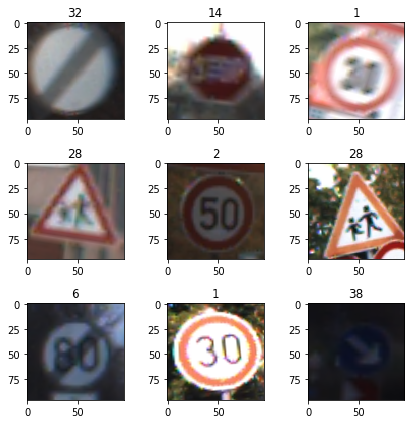

In [16]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [17]:
# data.valid_ds.classes

### Build Model and Train
We will use the same model as the one used in Lesson3 planet for this multiclassification task.

In [82]:
arch = models.resnet34

# use deeper cnn on good GPU
# arch = models.resnet50

In [83]:
learn = cnn_learner(data, arch, metrics=[accuracy])
# learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


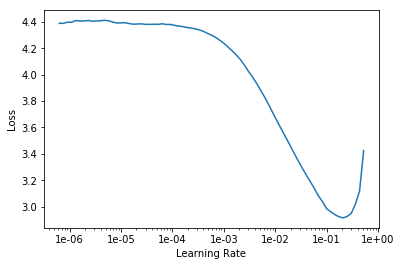

In [21]:
learn.recorder.plot()

In [18]:
lr = 0.01

In [19]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.526228,0.689086,0.787654,04:06


In [20]:
learn.save('stage-1-rn34-fp16')

In [21]:
# learn.load('stage-1-rn34-fp16')

#### Stage II

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


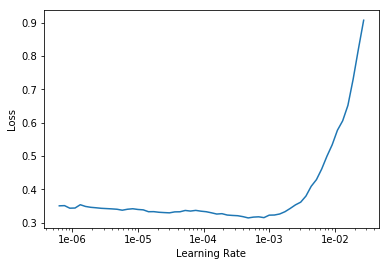

In [27]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.184484,0.434971,0.897668,05:08
1,0.056143,0.153213,0.963923,05:07
2,0.008076,0.044186,0.989163,05:07


In [24]:
learn.save('stage-2-rn34-fp16-l4')

#### train with larger size images

In [18]:
# if out of memory below, restart from here
learn.load('stage-2-rn34-fp16-l4')

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv

In [19]:
data = (src.transform(tfms, size=128)
       .databunch(bs=90))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [20]:
learn.to_fp32()
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


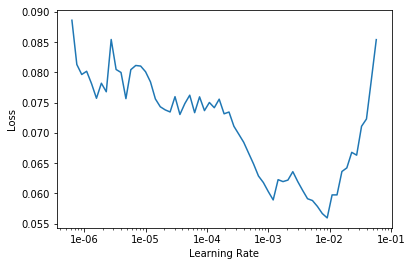

In [21]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr=1e-2

In [24]:
learn.fit_one_cycle(5, slice(1e-3, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.022769,0.056754,0.985322,05:23
1,0.021092,0.093814,0.984088,05:29
2,0.011286,0.095007,0.985460,05:36
3,0.005699,0.051693,0.991084,05:42
4,0.002439,0.051450,0.991358,05:35


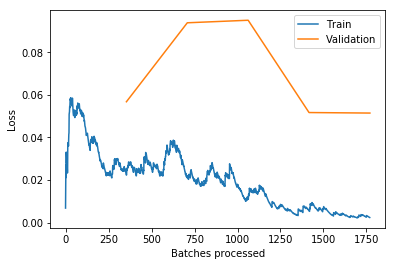

In [25]:
learn.recorder.plot_losses()

In [26]:
# learn.save('stage-1-128-rn34-l4')
learn.save('stage-1-128-rn34-best')

In [27]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.171843,0.462003,0.932785,07:29
1,0.076772,0.074178,0.975720,07:35
2,0.044904,0.065051,0.987654,07:37
3,0.008950,0.031472,0.991495,07:38
4,0.002448,0.015268,0.995473,07:38


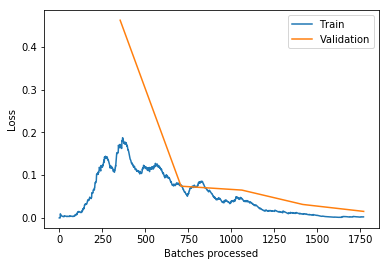

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-2-128-rn34-best')

In [32]:
# let us train it again with 8epoch
learn.load('stage-1-128-rn34-best')

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(8, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.076522,0.108426,0.975171,07:36
1,0.112505,0.236572,0.955693,07:44
2,0.075427,0.134190,0.967078,07:42
3,0.071039,0.093176,0.979012,07:47
4,0.021014,0.065313,0.988477,07:45
5,0.010858,0.028779,0.992455,07:45
6,0.003107,0.035669,0.992181,07:43
7,0.001287,0.025732,0.993964,07:44


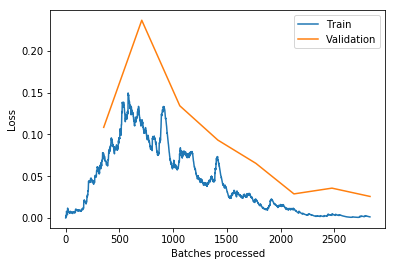

In [35]:
learn.recorder.plot_losses()

In [36]:
learn.save('stage-2b-128-rn34-best')

In [84]:
learn.load('stage-2b-128-rn34-best')

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv

#### stage 3: lr = slice(1e-5, 1e-2/5), try more epochs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


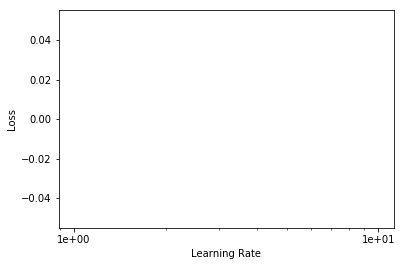

In [37]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.001172,0.024499,0.994376,05:29
1,0.001305,0.034032,0.992867,05:38
2,0.002026,0.029978,0.992593,05:42
3,0.000352,0.028428,0.992867,05:39
4,0.000552,0.026109,0.993964,05:48


#### Plot top losses

In [85]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [87]:
len(y),y

(7290, tensor([ 0,  0,  0,  ..., 42, 42, 42]))

In [93]:
len(preds), preds

(7290,
 tensor([[8.8126e-01, 2.2062e-02, 3.4823e-06,  ..., 3.8395e-06, 9.4673e-05,
          7.4321e-04],
         [7.7154e-01, 4.6874e-03, 3.5228e-06,  ..., 6.7905e-06, 3.7640e-04,
          2.5571e-04],
         [8.9065e-01, 5.2658e-02, 3.1729e-07,  ..., 1.3151e-06, 6.2597e-05,
          1.3444e-04],
         ...,
         [1.1079e-07, 5.1346e-08, 2.6012e-07,  ..., 1.1690e-07, 2.3917e-07,
          1.0000e+00],
         [7.4891e-08, 2.7097e-08, 1.4923e-07,  ..., 8.4697e-08, 2.3824e-07,
          1.0000e+00],
         [9.2220e-07, 1.9959e-07, 8.7911e-07,  ..., 3.1087e-07, 1.5175e-06,
          9.9998e-01]]))

In [96]:
probs = np.mean(preds,0)
probs

TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

In [95]:
print(accuracy(preds, y))

tensor(0.9365)


In [98]:
learn.to_fp32()
log_preds,y = learn.TTA()

In [99]:
len(log_preds), log_preds

(7290,
 tensor([[7.1445e-01, 9.9183e-03, 6.5638e-04,  ..., 7.7771e-04, 8.3824e-02,
          8.0564e-04],
         [7.1452e-01, 2.5273e-03, 3.2350e-05,  ..., 1.8452e-04, 1.2304e-01,
          1.8214e-04],
         [7.2801e-01, 2.2444e-02, 2.1380e-05,  ..., 1.2512e-03, 1.4490e-01,
          2.8394e-04],
         ...,
         [4.9377e-08, 2.9138e-08, 3.6589e-07,  ..., 5.7990e-08, 1.0307e-07,
          1.0000e+00],
         [3.5614e-08, 1.6142e-08, 1.5514e-07,  ..., 5.7684e-08, 1.0170e-07,
          1.0000e+00],
         [4.5999e-07, 5.5747e-07, 2.3566e-06,  ..., 2.1158e-07, 6.2446e-07,
          9.9999e-01]]))

In [105]:
probs = np.mean(np.exp(log_preds),0)

TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

In [102]:
probs

tensor(38359)

In [ ]:
accuracy(probs,y)

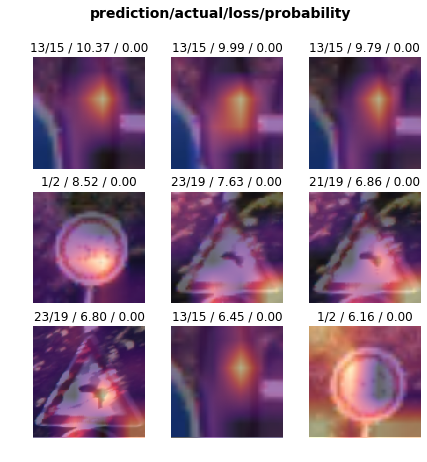

In [40]:
interp.plot_top_losses(9, figsize=(7,7))

## Export model 

In [43]:
learn.export()

## Testing on the test set

In [69]:
pd.read_csv(path/"GT-final_test.csv").head()

,Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId
0,00000.ppm;53;54;6;5;48;49;16
1,00001.ppm;42;45;5;5;36;40;1
2,00002.ppm;48;52;6;6;43;47;38
3,00003.ppm;27;29;5;5;22;24;33
4,00004.ppm;60;57;5;5;55;52;11


In [43]:
ftest_file = path/'GT-final_test.csv'
ftest_annots = read_annotations(ftest_file)

In [44]:
ftest_annots

[Annotation(filename='00000.ppm', label=16),
 Annotation(filename='00001.ppm', label=1),
 Annotation(filename='00002.ppm', label=38),
 Annotation(filename='00003.ppm', label=33),
 Annotation(filename='00004.ppm', label=11),
 Annotation(filename='00005.ppm', label=38),
 Annotation(filename='00006.ppm', label=18),
 Annotation(filename='00007.ppm', label=12),
 Annotation(filename='00008.ppm', label=25),
 Annotation(filename='00009.ppm', label=35),
 Annotation(filename='00010.ppm', label=12),
 Annotation(filename='00011.ppm', label=7),
 Annotation(filename='00012.ppm', label=23),
 Annotation(filename='00013.ppm', label=7),
 Annotation(filename='00014.ppm', label=4),
 Annotation(filename='00015.ppm', label=9),
 Annotation(filename='00016.ppm', label=21),
 Annotation(filename='00017.ppm', label=20),
 Annotation(filename='00018.ppm', label=27),
 Annotation(filename='00019.ppm', label=38),
 Annotation(filename='00020.ppm', label=4),
 Annotation(filename='00021.ppm', label=33),
 Annotation(file

In [12]:
def copy_one_file(label, filename, source, destination, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    destination_path = os.path.join(label_path, filename)
    if not os.path.exists(destination_path):
        func(os.path.join(source, filename), destination_path)


In [13]:
def process_final_test_ds(source_path, test_path):
    for filename, label in ftest_annots:
        copy_one_file(label, filename, source_path, test_path, move=False)

In [45]:
ftest_src = path/'ftest'
ftest_dest = path/'test'

process_final_test_ds(ftest_src, ftest_dest)

## Categorize final test images into sub-folders like train&valid folder

In [46]:
sd_train = ImageList.from_folder(path).split_by_folder('train', 'test').label_from_folder()

ll_train = sd_train.label_from_folder(); ll_train

LabelLists;

Train: LabelList (31919 items)
x: ImageList
Image (3, 30, 29),Image (3, 30, 30),Image (3, 29, 30),Image (3, 31, 31),Image (3, 31, 31)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (12630 items)
x: ImageList
Image (3, 39, 39),Image (3, 52, 51),Image (3, 44, 43),Image (3, 37, 37),Image (3, 47, 45)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: None

In [56]:
# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')

src_test = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder('train', 'test')              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder())              #Optionally add a test set (here default name is test)


In [66]:
data_test = (src_test.transform(tfms, size=96)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs))                   #Finally? -> use the defaults for conversion to ImageDataBunch
data_test

ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb

In [54]:
learn.to_fp32()
learn.validate()

[0.10881366, tensor(0.9565)]

In [62]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [63]:
preds

[tensor([[4.4387e-10, 1.0000e+00, 1.0973e-12, 7.7589e-12, 8.5495e-14, 1.8965e-12,
          6.6520e-12, 1.4397e-11, 5.9496e-12, 8.1267e-13, 8.3878e-12, 3.7577e-12,
          1.8322e-09, 3.2515e-15, 2.8013e-12, 1.4922e-12, 4.4162e-13, 5.3930e-12,
          5.3229e-11, 8.9216e-12, 5.3991e-12, 9.9199e-12, 1.1961e-14, 1.3426e-11,
          8.3668e-12, 3.9267e-13, 1.3942e-12, 1.9760e-15, 1.6366e-10, 3.8412e-13,
          6.6860e-13, 1.3493e-11, 8.2820e-12, 7.2868e-13, 4.8310e-10, 2.8123e-13,
          3.2514e-12, 7.9937e-14, 3.7353e-11, 7.2539e-12, 6.1705e-12, 1.3146e-12,
          4.4208e-10],
         [3.9270e-12, 3.3378e-11, 9.6489e-11, 1.0000e+00, 1.6175e-09, 8.4090e-10,
          1.5905e-09, 4.7041e-11, 1.1959e-09, 5.1852e-08, 3.2684e-09, 3.9110e-08,
          4.4970e-11, 1.6860e-08, 3.8029e-08, 3.1187e-10, 3.9548e-10, 2.3589e-10,
          6.3255e-10, 1.7833e-10, 1.3576e-08, 8.1848e-10, 4.9362e-12, 2.9391e-10,
          4.5741e-09, 6.5890e-11, 3.1157e-12, 3.3551e-10, 2.4895e-09, 3.312

In [64]:
len(learn.data.valid_ds)

23

In [65]:
len(preds[0]), len(preds[1])

(23, 23)

In [54]:
test_files = ImageList.from_folder(path/'test'); test_files
test_files.items[0].name

'00000.ppm'